# Conexão com postgres e Relatorios do Sistema

## Instalando biblioteca de acesso com postgres e manipulação de dados e gráficos

In [1]:
!pip install --user psycopg2-binary
!pip install --user seaborn
!pip install --user pandas

### Importando bibliotecas

In [2]:
import seaborn as sns
import pandas as pd
import psycopg2

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

### Usando psycopg2 para configurar conexão

In [3]:
conn = psycopg2.connect(host="tuffi.db.elephantsql.com",
                        database="xubzhvcc", 
                        user="xubzhvcc",
                        password="nXYY2mo9mt1RSIEAMG7F6rYw_ikut3hB")

## Obtendo dados do database com Pandas

# Relatório 1

### Objetivo: Obter a quantidade de lixo total coletado em determinado bairro em cada rota, evidenciando o caminhão que realizou aquela rota

Código para obtenção do resultado:

In [4]:
relat1 = pd.read_sql_query("""

                            SELECT
                                BAIRRO.nome as bairro,
                                sum(COLETA.volume) AS volumeT_coletado,
                                cod_caminhao
                            FROM BAIRRO
                            INNER JOIN LIXEIRA ON (BAIRRO.cod_bairro = LIXEIRA.cod_bairro)
                            INNER JOIN COLETA ON (LIXEIRA.cod_lixeira = COLETA.cod_lixeira)
                            GROUP BY BAIRRO.nome, COLETA.cod_caminhao
                            ORDER BY volumeT_coletado
                            
                        """,conn)

In [5]:
relat1

,bairro,volumet_coletado,cod_caminhao
0,Centro de Vitória,90.00,3
1,Carapina,294.00,1
2,Porto de Santana,297.00,3
3,Centro de Vitória,409.50,2
4,Grande Goiabeiras,500.02,2
5,Grande Goiabeiras,535.90,1
6,Colina de Laranjeiras,614.00,3


# Relatório 2

### Objetivo: Obter a quantidade de descartes e o volume descartado em determinada lixeira, por dia

codigo para obtenção do resultado:

In [6]:
relat2 = pd.read_sql_query("""

                            SELECT
                                cod_lixeira,
                                count(DESCARTE.cod_lixeira) as qnt_descarte,
                                sum(DESCARTE.volume) as volume_total
                            FROM DESCARTE
                            GROUP BY cod_lixeira, data_descarte
                            ORDER BY volume_total DESC
                            
                            """, conn)

In [7]:
relat2

,cod_lixeira,qnt_descarte,volume_total
0,17,4,296.8
1,3,4,204.4
2,10,1,200.0
3,2,4,194.0
4,4,3,185.7
5,16,3,180.0
6,1,3,144.0
7,15,3,127.8
8,9,1,120.0
9,13,1,110.0


## Relatório 3

### Objetivo: Mostrar quantas vezes cada caminhão foi alocado, verificar quais estão sendo mais utilizados e os dados (placa, modelo, marca) dos mesmos

codigo para obtenção do resultado:

In [8]:
relat3 = pd.read_sql_query("""

                            SELECT
                                CAMINHAO.cod_caminhao,
                                placa,
                                MODELO.nome AS modelo,
                                MARCA.nome AS marca,
                                count(ALOCA.cod_caminhao) AS qnt_aloca
                            FROM CAMINHAO
                            INNER JOIN ALOCA ON (CAMINHAO.cod_caminhao = ALOCA.cod_caminhao)
                            INNER JOIN MODELO ON (CAMINHAO.cod_modelo = MODELO.cod_modelo)
                            INNER JOIN MARCA ON (MODELO.cod_marca = MARCA.cod_marca)
                            GROUP BY CAMINHAO.cod_caminhao, ALOCA.cod_caminhao, MODELO.cod_modelo, MARCA.cod_marca
                            ORDER BY qnt_aloca DESC
                            
                            """,conn)

In [9]:
relat3

,cod_caminhao,placa,modelo,marca,qnt_aloca
0,1,MTR3338,2540,Mercedes Benz,2
1,3,MQZ8687,G 440,Scania,1
2,2,MTV4311,MB Axor 2036,Mercedes Benz,1


## Relatório 4

### Objetivo: Verificar quantidade de lixeiras em cada Status Operacional

Codigo para obtenção do resultado:

In [10]:
relat4 = pd.read_sql_query("""

                            SELECT 
                                STATUS.cod_status,
                                status.descricao AS situacao_lixeira, 
                                count(SITUACAO_OPERACIONAL.cod_status) AS contagem
                            FROM SITUACAO_OPERACIONAL
                            INNER JOIN STATUS ON (SITUACAO_OPERACIONAL.cod_status = STATUS.cod_status)
                            GROUP BY (STATUS.cod_status)
                            ORDER BY contagem
    
                            """,conn)

In [11]:
relat4

,cod_status,situacao_lixeira,contagem
0,2,Não atende a demanda,2
1,1,Quebrada,4


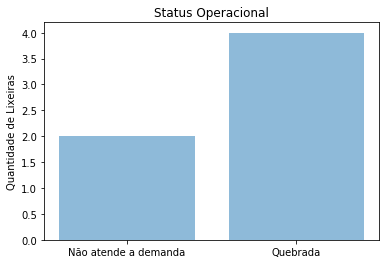

In [12]:
df = pd.DataFrame(relat4)
cm = sns.light_palette("blue", as_cmap=True)
df.style.background_gradient(cmap=cm)
 
objects = tuple(df.situacao_lixeira)
y_pos = np.arange(len(objects))
performance = list(df.contagem)
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Quantidade de Lixeiras')
plt.title('Status Operacional')

plt.show()

## Relatório 5

### Objetivo: Verificar quais lixeiras se encontram quebradas, para eventual troca, mostrando o código da lixeira, o bairro onde se encontra e suas coordenadas geográficas

Codigo para obtenção do resultado:

In [13]:
relat5 = pd.read_sql_query("""

                            SELECT 
                                LIXEIRA.cod_lixeira,
                                BAIRRO.nome,
                                latitude,
                                longitude
                            FROM SITUACAO_OPERACIONAL
                            INNER JOIN STATUS ON (SITUACAO_OPERACIONAL.cod_status = STATUS.cod_status)
                            INNER JOIN COLETA ON (SITUACAO_OPERACIONAL.cod_coleta = COLETA.cod_coleta)
                            INNER JOIN LIXEIRA ON (COLETA.cod_lixeira = LIXEIRA.cod_lixeira)
                            INNER JOIN BAIRRO ON (LIXEIRA.cod_bairro = BAIRRO.cod_bairro)
                            WHERE STATUS.descricao = 'Quebrada'
                            
                            """,conn)

In [14]:
relat5

,cod_lixeira,nome,latitude,longitude
0,9,Centro de Vitória,-20.196950,-40.251233
1,10,Centro de Vitória,-20.196958,-40.252933
2,13,Colina de Laranjeiras,-20.193958,-40.193958
3,14,Colina de Laranjeiras,-20.196958,-40.196958


# Referencias

https://pandas.pydata.org/pandas-docs/stable/style.html <br>
https://pythonspot.com/matplotlib-bar-chart/<br>
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html <br>